In [ ]:
## Author- Sayan Chandra
## Roll - CS20M057
## Instructor - Mitesh M. Khapra
## Course - CS6910 (Fundamentals of Deep Learning)

In [ ]:
## importing all necessary modules
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

import torch
import torch.nn as cnn
import torch.optim as optimisations
from torch.nn import functional as func
from torch.utils.data import DataLoader as dataloader, ConcatDataset
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable

In [ ]:
!pip install split-folders
import splitfolders as sf

In [ ]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
!unzip nature_12K.zip

In [ ]:
MAINPATH = "/content/inaturalist_12K/"
sf.fixed(MAINPATH + "train", output=MAINPATH+"train_split", seed=1337, fixed=100, oversample=False, group_prefix=None)

Copying files: 9999 files [01:24, 118.01 files/s]


In [ ]:
sizew=224; sizeh=224
data_transforms1 = transforms.Compose([
        transforms.Resize((sizew, sizeh)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
data_transforms2 = transforms.Compose([
        transforms.Resize((sizew, sizeh)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [ ]:
BATCH_SIZE=32
EPOCHS=14  
TESTPATH="/content/inaturalist_12K/val"
def yo(): # no arguments
  train_data = torchvision.datasets.ImageFolder(root=MAINPATH+"train_split/train/", transform=data_transforms1)
  val_data = torchvision.datasets.ImageFolder(root=MAINPATH+"train_split/val/", transform=data_transforms2)
  test_data = torchvision.datasets.ImageFolder(root=TESTPATH, transform=data_transforms2)
  return train_data, test_data, val_data
train_data1,test_data,val_data=yo()
def loadTrain_Val_TestData(): # no arguments
  train_data = torchvision.datasets.ImageFolder(root=MAINPATH+"train_split/train/", transform=data_transforms2)
  return train_data
train_data2 = loadTrain_Val_TestData()
train_data_loader = dataloader(ConcatDataset([train_data1,train_data2]), batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=1) #ConcatDataset([train_data1,train_data2])
val_data_loader = dataloader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=1)
test_data_loader  = dataloader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=1)

In [ ]:
numOfConvPoolLayers=5
sizew=224; sizeh=224
cnn_config=[[3, 64, 11, 2, (0, 0), 2, 1],
            [64, 64, 7, 2, (0, 0), 2, 1],
            [64, 32, 5, 2, (0, 0), 2, 1],
            [32, 32, 3, 1, (0, 0), 2, 1],
            [32, 32, 3, 1, (0, 0), 2, 1],
            "relu"] ## in, out, kernel, stride, pad, actv, maxpoolkernel, maxpoolstride
denseLayer=64
def computeFirstDenseLayer():
  w,h,d=sizew,sizeh,3
  for i in range( numOfConvPoolLayers):
    d=cnn_config[i][1]
    w=1+np.floor((w-cnn_config[i][2]+2* cnn_config[i][4][0])/cnn_config[i][3])
    w=1+np.floor((w-cnn_config[i][5])/cnn_config[i][6])
    h=w#1+np.floor((h-cnn_config[i][5])/cnn_config[i][6])
    #print(w,h)
  return w*h*d
print(computeFirstDenseLayer())
def computeNumberOfParameters():
  add=0
  w,h,d=sizew,sizeh,3
  for i in range( numOfConvPoolLayers):
    d=cnn_config[i][1]
    add+=d*cnn_config[i][1]*(cnn_config[i][2]**2)
  return add
computeNumberOfParameters()+(denseLayer*computeFirstDenseLayer()+denseLayer)+(10*denseLayer+10)

8192.0


1265354.0

In [ ]:
class CNN(cnn.Module):
  def __init__(self, cnn_config, in_channels=3, num_classes=10, denseLayer=denseLayer):
    super(CNN, self).__init__()

    self.conv1=cnn.Conv2d(in_channels=cnn_config[0][0], out_channels=cnn_config[0][1], kernel_size= cnn_config[0][2], stride= cnn_config[0][3], padding= cnn_config[0][4])
    cnn.init.xavier_uniform_(self.conv1.weight)
    self.activ=self.Activ2d(cnn_config[numOfConvPoolLayers])
    self.batchnorm1=cnn.BatchNorm2d(cnn_config[0][1])
    self.maxpool1=cnn.MaxPool2d(cnn_config[0][5], stride=cnn_config[0][6])

    self.conv2=cnn.Conv2d(in_channels=cnn_config[1][0], out_channels=cnn_config[1][1], kernel_size= cnn_config[1][2], stride= cnn_config[1][3], padding= cnn_config[1][4])
    cnn.init.xavier_uniform_(self.conv2.weight)
    self.batchnorm2=cnn.BatchNorm2d(cnn_config[1][1])
    self.maxpool2=cnn.MaxPool2d(cnn_config[1][5], stride=cnn_config[1][6])
    
    self.conv3=cnn.Conv2d(in_channels=cnn_config[2][0], out_channels=cnn_config[2][1], kernel_size= cnn_config[2][2], stride= cnn_config[2][3], padding= cnn_config[2][4])
    cnn.init.xavier_uniform_(self.conv3.weight)
    self.batchnorm3=cnn.BatchNorm2d(cnn_config[2][1])
    self.maxpool3=cnn.MaxPool2d(cnn_config[2][5], stride=cnn_config[2][6])

    self.conv4=cnn.Conv2d(in_channels=cnn_config[3][0], out_channels=cnn_config[3][1], kernel_size= cnn_config[3][2], stride= cnn_config[3][3], padding= cnn_config[3][4])
    cnn.init.xavier_uniform_(self.conv4.weight)
    self.batchnorm4=cnn.BatchNorm2d(cnn_config[3][1])
    self.maxpool4=cnn.MaxPool2d(cnn_config[3][5], stride=cnn_config[3][6])

    self.conv5=cnn.Conv2d(in_channels=cnn_config[4][0], out_channels=cnn_config[4][1], kernel_size= cnn_config[4][2], stride= cnn_config[4][3], padding= cnn_config[4][4])
    cnn.init.xavier_uniform_(self.conv5.weight)
    self.batchnorm5=cnn.BatchNorm2d(cnn_config[4][1])
    self.maxpool5=cnn.MaxPool2d(cnn_config[4][5], stride=cnn_config[4][6])
    
    self.val=computeFirstDenseLayer().astype(int)
    self.fullconn1=cnn.Linear(in_features=self.val, out_features= denseLayer)
    cnn.init.xavier_uniform_(self.fullconn1.weight)
    self.dropout=cnn.Dropout(p=0.2)
    self.output=cnn.Linear(in_features= denseLayer, out_features= num_classes)

  def forward(self, curinp):
    out=self.maxpool1(self.batchnorm1(self.activ(self.conv1(curinp))))
    out=self.maxpool2(self.batchnorm2(self.activ(self.conv2(out))))
    out=self.maxpool3(self.batchnorm3(self.activ(self.conv3(out))))
    out=self.maxpool4(self.batchnorm4(self.activ(self.conv4(out))))
    out=self.maxpool5(self.activ(self.conv5(out))) #self.batchnorm5(

    out=out.view(-1, self.val)
    out=self.activ(self.fullconn1(out))
    out=self.dropout(out)
    out=func.softmax(self.output(out), dim=1)

    return out

  def Activ2d(self, str):
    if str=="relu" : return func.relu


In [ ]:
cnnModel=CNN(cnn_config)
heyGPU=torch.cuda.is_available()
if heyGPU: cnnModel=cnnModel.cuda()
lossfunc=cnn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnnModel.parameters(), lr=0.0022, momentum=0.94, weightdecay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=int(np.ceil(len(train_data_loader)/BATCH_SIZE)))


106.0 106.0
49.0 49.0
22.0 22.0
19.0 19.0
16.0 16.0


In [ ]:
keep_pred=[]
keep_prob=[]
keep_img=[]
keep_true=[]
yes=1
def trainMyModel(EPOCHS, train_data_loader, heyGPU, optimizer, scheduler, data_loader):
    itr=0
    for run in range(EPOCHS):
      globalloss=0
      for i, (curimg, ytrue) in enumerate(train_data_loader):
        itr+=1
        if heyGPU : curimg, ytrue=Variable(curimg.cuda()), Variable(ytrue.cuda())
        else : curimg, ytrue=Variable(curimg), Variable(ytrue)
        #print("yoo")
        optimizer.zero_grad()
        outputt=cnnModel(curimg)
        curloss=lossfunc(outputt, ytrue)
        globalloss+=curloss.item()
        curloss.backward()
        optimizer.step()
        scheduler.step()
        #print("yooy")

        
      predictedright=0
      totalimgs=0
      with torch.no_grad():
          for img, y in data_loader:
              if heyGPU : img, y=Variable(img.cuda()), Variable(y.cuda())
              else : img, y=Variable(img), Variable(y)
              outp=cnnModel(img)
              ignore, predicted = torch.max(outp.data, 1)
              if run==9 and yes: 
                 keep_pred.append(predicted)
                 keep_prob.append(outp)
                 keep_img.append(img)
                 keep_true.append(y)
                 yes=0
              totalimgs+=y.size(0)
              if heyGPU : predictedright+=(predicted.cpu()==y.cpu()).sum()
              else : predictedright+=(predicted==y).sum()
      curaccuracy=(predictedright/totalimgs)*100
      print(itr, globalloss/(2*len(train_data1)), curaccuracy.item()) 
trainMyModel(EPOCHS, train_data_loader, heyGPU, optimizer, scheduler, test_data_loader)

In [ ]:
np.save("saved4",[keep_img[0], keep_pred[0], keep_prob[0], keep_true[0]])
#np.load("saved4.npy")
def denormalizeImg(pic):
  mu, sd = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
  good = pic.cpu() * torch.tensor(sd).view(3, 1, 1).cpu() + torch.tensor(mu).view(3, 1, 1)
  img = transforms.ToPILImage(mode='RGB')(good)
  return img

allimg=[]
for i in keep_img[0]: allimg.append(denormalizeImg(i))

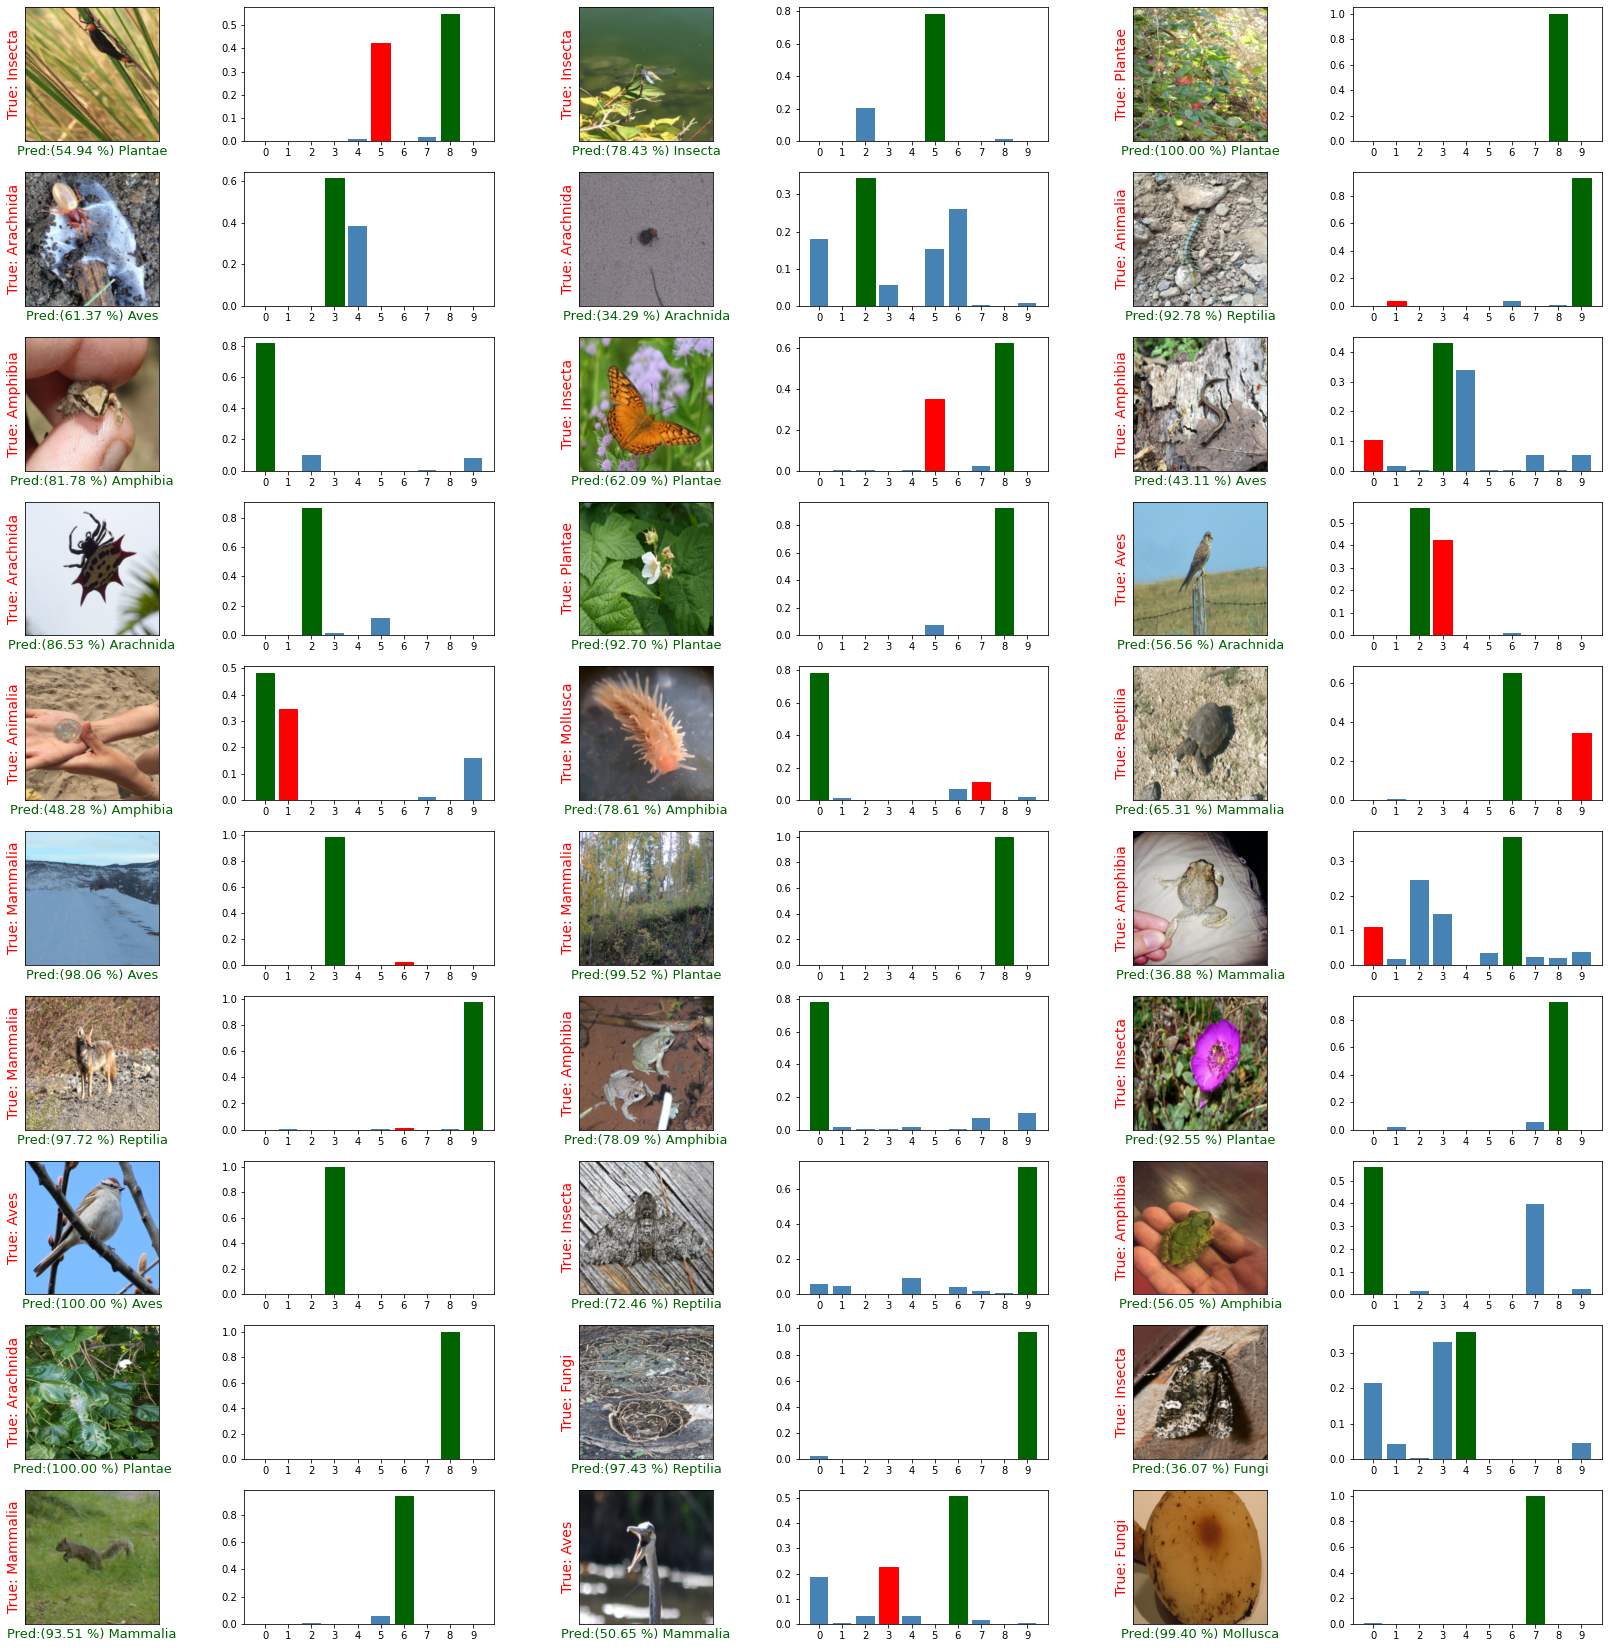

In [ ]:
races = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
myfig=plt.figure(figsize=(23,23))
for x in range(60):
    myfig.add_subplot(10, 6, x+1)
    if x%2==0 :
      plt.imshow(allimg[x//2])
      plt.ylabel("True: "+ races[keep_true[0][x//2].item()], fontsize=14).set_color('red')
      plt.xlabel("Pred:("+ str(format(max(keep_prob[0][x//2].cpu()).item()*100, '.2f'))+ " %) " + races[keep_pred[0][x//2].item()], fontsize=13).set_color('darkgreen')
      plt.xticks([])
      plt.yticks([])
    else:
      gg=plt.bar([i for i in range(10)], np.array(keep_prob[0][x//2].cpu()), color='steelblue')
      plt.xticks(range(10))
      gg[keep_true[0][x//2].item()].set_color('red')
      gg[keep_pred[0][x//2].item()].set_color('darkgreen')
    plt.grid(False)
myfig.tight_layout()
myfig.savefig("Part-A_Ques-4(b).png")

Text(0.5, 1.0, 'visualize_conv1_filters')

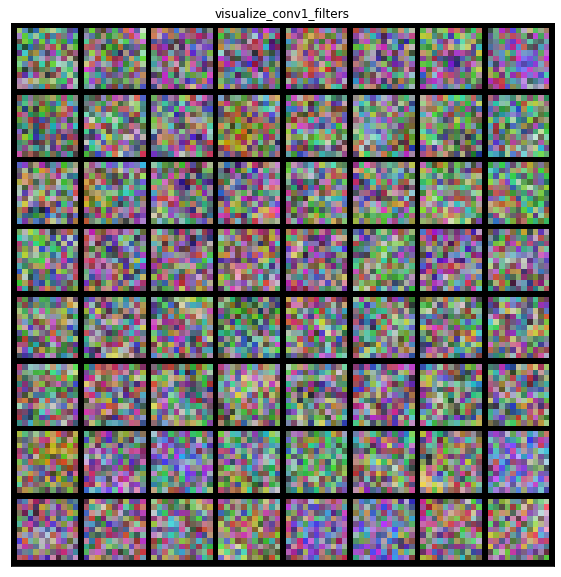

In [ ]:
filters = cnnModel.conv1.weight.detach().clone()
filters = (filters - filters.min())
filters = filters / filters.max()

filter_img = torchvision.utils.make_grid(filters, nrow = 8, normalize=1, padding=1).cpu()
plt.figure(figsize = (10, 10)).savefig('visualize_conv1_filters.png')
plt.imshow(filter_img.permute(1, 2, 0), interpolation='nearest')
plt.xticks([]); plt.yticks([]); plt.title('visualize_conv1_filters')